In [0]:
pip install --upgrade google-cloud-bigquery

     |████████████████████████████████| 163kB 2.8MB/s 
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.13.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
  Found existing installation: google-cloud-bigquery 1.21.0
    Uninstalling google-cloud-bigquery-1.21.0:
      Successfully uninstalled google-cloud-bigquery-1.21.0


In [47]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'capstone-247602'
client = bigquery.Client(project=project_id)

for dataset in client.list_datasets():
  print(dataset.dataset_id)

import pandas as pd

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'capstone-247602'
df_full = pd.io.gbq.read_gbq('''
SELECT * FROM `capstone-247602.combined_digital_linear.tbl_title_matching_stage_3_FINAL`''', 
project_id=project_id, verbose=False)


Digital_Data
Nielsen_Data
combined_digital_linear
predictions


In [0]:
# imports
import math, datetime
import numpy as np
import pandas as pd
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from matplotlib import style

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from statsmodels.stats.outliers_influence import variance_inflation_factor

style.use('ggplot')

In [0]:
# VIF function
from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=10.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [85]:
df_seasons = df_full.groupby('Series_Name').nunique()['season_number'].sort_values(ascending=False)
df_seasons.head(5)

Series_Name
SPECIALS                14
VOICE                   10
AMERICA'S GOT TALENT     7
CHICAGO PD               6
BLACKLIST                6
Name: season_number, dtype: int64

In [0]:
import warnings
warnings.filterwarnings("ignore")

show_name = "SUPERSTORE"
show_table = df_full[df_full.Show_Name == show_name]
show_table['days_since_last_episode'] = show_table.groupby('Season')['airdate'].diff().fillna(0).astype(str).str[:2]
show_table['days_since_1st_episode'] = (show_table.airdate - show_table.airdate.min()).astype(str).str[:2]

show_table['airdate']= pd.to_datetime(show_table['airdate']) 
show_table = show_table.set_index('airdate')


df_amv = show_table[[ 'average_mins_viewed','days_since_last_episode','days_since_1st_episode','dummy_weekday','dummy_10pm','dummy_9pm','dummy_8pm',
                     'quarter','Median_Age','Median_Income','season_number','Season','episode_number']]

df_I = show_table[[ 'Imps','days_since_last_episode','days_since_1st_episode','dummy_weekday','dummy_10pm','dummy_9pm','dummy_8pm',
                 'quarter','Median_Age','Median_Income','season_number','Season','episode_number']]

forecast_cols = ['average_mins_viewed', 'Imps']
dfs = [df_amv,df_I]



In [0]:
# remove outlyers
from scipy import stats
import numpy as np


threshold = 3
#print(np.where(z > 3))

for i in dfs:
  Q1 = i.quantile(0.25)
  Q3 = i.quantile(0.75)
  IQR = Q3 - Q1
  i = i[~((i < (Q1 - 1.5 * IQR)) |(i > (Q3 + 1.5 * IQR))).any(axis=1)]


In [188]:
#Average Mins Viewed ______________________________

forecast_col = 'average_mins_viewed'

df_amv.fillna(-99999, inplace=True)

# number to forecast out
forecast_out = 30 #int(math.ceil(0.01*len(df)))

df_amv['label'] = df_amv[forecast_col].shift(-forecast_out)

# define variables
X = np.array(df_amv.drop(['label'],1))
Xv = df_amv.drop(['label'],1)

# Scale X - all values have to be scaled together

#X = preprocessing.scale(X)
#X = X[:-forecast_out]
#X_lately = X[-forecast_out:]

df_amv.dropna(inplace=True)
y = np.array(df_amv['label'])
yv = df_amv['label']
print(len(X),len(X_lately),len(y))


#Imps____________________________________________________________________

forecast_coli = 'Imps'

df_I.fillna(-99999, inplace=True)

# number to forecast out
forecast_out = 30 #int(math.ceil(0.01*len(df)))

df_I['label'] = df_I[forecast_coli].shift(-forecast_out)

# define variables
Xi = np.array(df_I.drop(['label'],1))
Xvi = df_I.drop(['label'],1)

# Scale X - all values have to be scaled together

#Xi = preprocessing.scale(Xi)
#Xi = Xi[:-forecast_out]
#Xi_lately = Xi[-forecast_out:]

df_I.dropna(inplace=True)
yi = np.array(df_I['label'])
yvi = df_I['label']

print(len(Xi),len(Xi_lately),len(yi))


69 30 39
69 9 39


In [189]:
transformer = ReduceVIF()

# Only use 10 columns for speed in this example
X = transformer.fit_transform(Xv[Xv.columns], yv)
X = preprocessing.scale(X)
X = X[:-forecast_out]
X_lately = X[-forecast_out:]

Xi = transformer.fit_transform(Xvi[Xvi.columns], yvi)
Xi = preprocessing.scale(Xi)
Xi = Xi[:-forecast_out]
Xi_lately = Xi[-forecast_out:]

print(len(X),len(X_lately),len(y))
print(len(Xi),len(Xi_lately),len(yi))

ReduceVIF fit
ReduceVIF transform
Dropping dummy_10pm with vif=inf
Dropping season_number with vif=inf
Dropping dummy_weekday with vif=30202673.005659606
Dropping Median_Age with vif=2271.4663919321033
Dropping Season with vif=438.6408634077301
Dropping Median_Income with vif=206.13454181281884
Dropping dummy_8pm with vif=73.04401070429866
Dropping average_mins_viewed with vif=14.253079555101047
ReduceVIF fit
ReduceVIF transform
Dropping dummy_10pm with vif=inf
Dropping season_number with vif=inf
Dropping dummy_weekday with vif=28504302.86538551
Dropping Season with vif=3508.780062188702
Dropping Median_Age with vif=1383.9371105100488
Dropping Median_Income with vif=147.19922156586426
Dropping dummy_8pm with vif=37.25262094588475
Dropping Imps with vif=12.036531110219794
39 30 39
39 30 39


In [190]:
#Single variable run

# Split testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size = 0.30, random_state=42)
Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi ,test_size = 0.30, random_state=42)

# Train Model - set clf to the model you want to use
clf = LinearRegression(fit_intercept=True,normalize=True,copy_X=True,n_jobs=10)
clfi = LinearRegression(fit_intercept=True,normalize=True,copy_X=True,n_jobs=10)
#clf = svm.SVR()
#clfi = linear_model.Ridge(alpha=.5)
#clfi = linear_model.Lasso(alpha=0.1)
#clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)
clfi.fit(Xi_train, yi_train)

accuracy = clf.score(X_test, y_test)
accuracyi = clfi.score(Xi_test, yi_test)

#print(accuracy)

# Forecast using the older data
forecast_set = clf.predict(X_lately)
forecast_seti = clfi.predict(Xi_lately)

print(forecast_set, accuracy, forecast_out)
print(forecast_seti, accuracyi, forecast_out)


[1421225.65306882 1532218.00729394 1552559.76216557 1579925.50297572
 1607291.24378588 1627632.99865751 1654998.73946766 1592389.21326821
 1507288.07946878 1578828.33177629 1569043.54702761 1596409.28783777
 1623775.02864792 1688291.2950169  1678506.51026823 1811586.12024203
 1838951.86105218 1851254.33205219 1878620.07286234 1618342.36730229
 1744397.99133757 1771763.73214772 1792105.48701935 1819471.22782951
 1846836.96863966 1799290.71225037 1706150.29457931 1733516.03538946
 1753857.79026109 1781223.53107124] 0.41798319706159104 30
[5171148.75578736 4920661.75354514 4856882.33027164 4781883.6859227
 4706885.04157377 4643105.61830027 4568106.97395133 4497638.04018397
 4835918.45135808 4623607.12644467 4674701.94158478 4599703.29723584
 4524704.6528869  4323612.54904893 4374707.36418903 4055564.02166458
 3980565.37731564 3963003.85217351 3888005.20782457 4952252.76282548
 4644328.64137645 4569329.99702752 4505550.57375402 4430551.92940508
 4355553.28505615 4227647.23208199 4612145.54

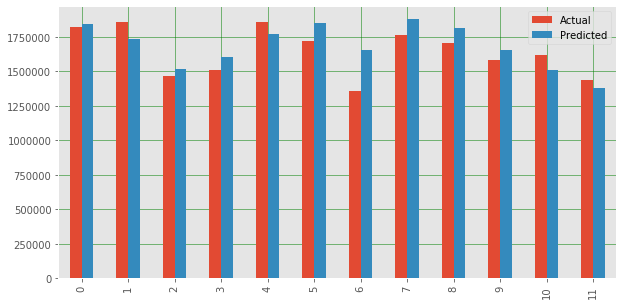

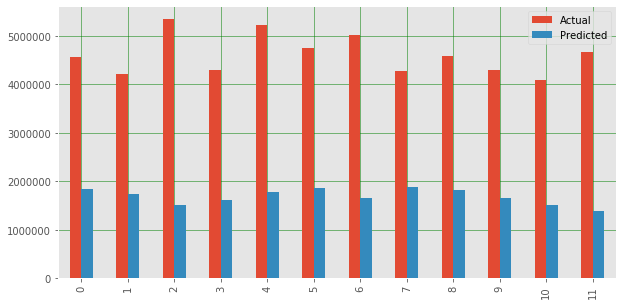

In [191]:
y_pred = clf.predict(X_test)

df_compare = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

df1 = df_compare.head(50)
df1.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

yi_pred = clf.predict(Xi_test)

df_comparei = pd.DataFrame({'Actual': yi_test.flatten(), 'Predicted': yi_pred.flatten()})

df1i = df_comparei.head(50)
df1i.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [0]:
#Single run

df_amv['Forecast_amv'] = np.nan

# Set up forecasting dates
last_date =df_amv.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
one_week = 604800
next_unix = last_unix + one_week #one_day

# add forecast rows to dataframe for Average Mins Viewed
for i in forecast_set:
  next_date = datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_week #one_day
  df_amv.loc[next_date] = [np.nan for _ in range(len(df_amv.columns)-1)] + [i]


df_I['Forecast_I'] = np.nan
# Set up forecasting dates
last_date =df_I.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
one_week = 604800
next_unix = last_unix + one_week #one_day

# add forecast rows to dataframe for Imps
for j in forecast_seti:
  next_date = datetime.datetime.fromtimestamp(next_unix)
  next_unix += one_week #one_day
  df_I.loc[next_date] = [np.nan for _ in range(len(df_I.columns)-1)] + [j]


df_I = df_I[[ 'Imps','Forecast_I']]
df = pd.merge(df_amv, df_I, left_index=True, right_index=True)


df['Percent_Digital_Viewership'] = (df.average_mins_viewed.fillna(0) + df.Forecast_amv.fillna(0)) / (df.average_mins_viewed.fillna(0) + df.Forecast_amv.fillna(0) + df.Imps.fillna(0) + df.Forecast_I.fillna(0))
df['Percent_Linear_Viewership'] = (df.Imps.fillna(0) + df.Forecast_I.fillna(0)) / (df.average_mins_viewed.fillna(0) + df.Forecast_amv.fillna(0) + df.Imps.fillna(0) + df.Forecast_I.fillna(0))


1it [00:05,  5.85s/it]


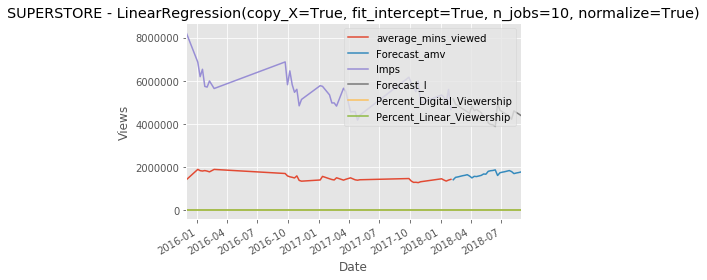

In [193]:
# Single Run

# plot the forecasts
df['airdate'] = df.index

import pandas_gbq as gbq
gbq.to_gbq(df, 'predictions.SUPERSTORE', project_id, if_exists='replace')

df['average_mins_viewed'].plot()
df['Forecast_amv'].plot()
df['Imps'].plot()
df['Forecast_I'].plot()
df['Percent_Digital_Viewership'].plot()
df['Percent_Linear_Viewership'].plot()
plt.legend(loc=1)
plt.xlabel('Date')
plt.ylabel('Views')
plt.title(show_name + " - " + str(clf))
plt.show()


In [12]:
import warnings
warnings.filterwarnings("ignore")

# Model Eval

df = show_table[[ 'average_mins_viewed','days_since_last_episode','days_since_1st_episode','dummy_weekday','dummy_10pm','dummy_9pm','dummy_8pm',
                 'Season',  'episode_number','season_number','quarter','Median_Age','Median_Income']]

# Holding all other variables fixed, being a suburban area is associated with an average decrease in Sales of 106.56 widgets 
# (as compared to the baseline level, which is rural).
# Being an urban area is associated with an average increase in Sales of 268.13 widgets (as compared to rural).

feature_cols = ['days_since_last_episode','days_since_1st_episode','dummy_weekday','dummy_10pm','dummy_9pm','dummy_8pm',
                 'Season',  'episode_number','season_number','quarter','Median_Age','Median_Income']
X = df[feature_cols]
y = df.average_mins_viewed

# instantiate and fit
lm2 = clf
lm2.fit(X, y)

# print the coefficients
list(zip(feature_cols, lm2.coef_))

[('days_since_last_episode', -406.8707312689925),
 ('days_since_1st_episode', -4487.17056139845),
 ('dummy_weekday', 346887654724623.2),
 ('dummy_10pm', 2733676609800670.5),
 ('dummy_9pm', 44208171110094.28),
 ('dummy_8pm', 2733676610393528.0),
 ('Season', 1.1060220636700408e+16),
 ('episode_number', -1927.4081010316988),
 ('season_number', -1.1060220636798316e+16),
 ('quarter', -54833.67759377455),
 ('Median_Age', 66482.1416611057),
 ('Median_Income', 21.599173507876692)]

In [157]:
import warnings
warnings.filterwarnings("ignore")

# Model Eval

df = show_table[[ 'Imps','days_since_last_episode','days_since_1st_episode','dummy_weekday','dummy_10pm','dummy_9pm','dummy_8pm',
                 'Season',  'episode_number','season_number','quarter','Median_Age','Median_Income']]

# Holding all other variables fixed, being a suburban area is associated with an average decrease in Sales of 106.56 widgets 
# (as compared to the baseline level, which is rural).
# Being an urban area is associated with an average increase in Sales of 268.13 widgets (as compared to rural).

feature_cols = ['days_since_last_episode','days_since_1st_episode','dummy_10pm','dummy_9pm','dummy_8pm',
                 'Season',  'episode_number','season_number','Median_Age','Median_Income']
X = df[feature_cols]
y = df.Imps

# instantiate and fit
lm2 = clf
lm2.fit(X, y)

# print the coefficients
list(zip(feature_cols, lm2.coef_))

[('days_since_last_episode', 6935.53990045886),
 ('days_since_1st_episode', 2902.4678391760735),
 ('dummy_10pm', -3.756726407827688e+16),
 ('dummy_9pm', -2508072005885058.5),
 ('dummy_8pm', -3.7567264079942184e+16),
 ('Season', -1.2207947091523376e+17),
 ('episode_number', -52006.16826457772),
 ('season_number', 1.2207947091500091e+17),
 ('Median_Age', 105256.98022868691),
 ('Median_Income', -68.50150093448597)]

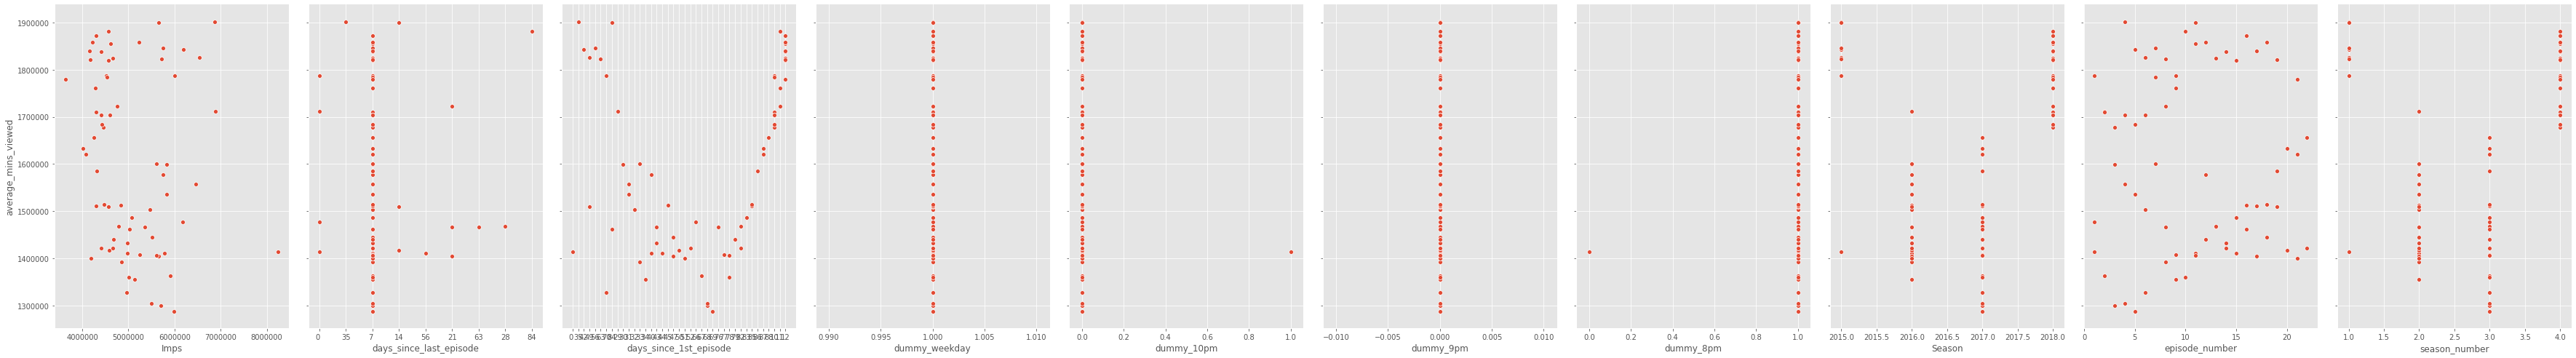

In [0]:
# imports
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np

# allow plots to appear directly in the notebook
%matplotlib inline

# visualize the relationship between the features and the response using scatterplots
sns.pairplot(df, x_vars=['Imps','days_since_last_episode','days_since_1st_episode','dummy_weekday','dummy_10pm','dummy_9pm','dummy_8pm','Season',  'episode_number','season_number'], y_vars='average_mins_viewed', size=7, aspect=0.7)

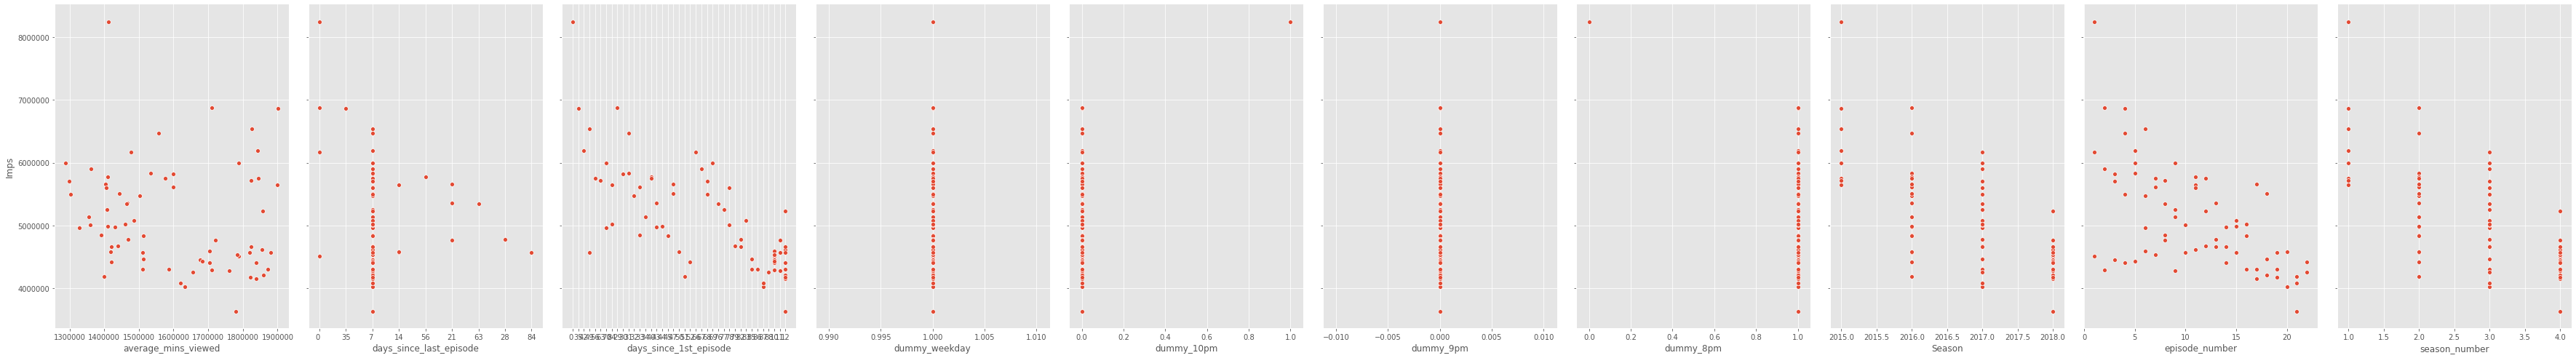

In [0]:
# imports
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np

# allow plots to appear directly in the notebook
%matplotlib inline

# visualize the relationship between the features and the response using scatterplots
sns.pairplot(df, x_vars=['average_mins_viewed','days_since_last_episode','days_since_1st_episode','dummy_weekday','dummy_10pm','dummy_9pm','dummy_8pm','Season',  'episode_number','season_number'], y_vars='Imps', size=7, aspect=0.7)

In [0]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_amv.corr(), fignum=f.number)
plt.xticks(range(df_amv.shape[1]), df_amv.columns, fontsize=14, rotation=90)
plt.yticks(range(df_amv.shape[1]), df_amv.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);